In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import requests 
from bs4 import BeautifulSoup as bs
from wordcloud import WordCloud, STOPWORDS

# REST API

To get our data we need a URI. Using the API we can generate a link to use. Notice that we have `PrizeCategory=phy` since we only want to look at physics prizes, and `limit=10000` since otherwise we would only get 25 prizes in the response.

In [2]:
URI = "http://api.nobelprize.org/2.1/nobelPrizes?limit=10000&nobelPrizeCategory=phy"
response = requests.get(URI)
nobel = response.json()

We'll want to loop through all prizes and collect the motivations within. Since each prize can have multiple laureates, and these laureates can have different motivations, we'll have to loop through all laureates in each prize and get their individual motivations. However, some years prizes were not awarded, so no laureates or motivations are given, and we need to make a check for those years.

In [3]:
# the words to use for the word cloud
words = ""

# looping through each prize
for prize in nobel["nobelPrizes"]:
    # checking if a prize was given out that year
    if "laureates" in prize.keys():
        # looping though each laureate and adding their motivation
        for laureate in prize["laureates"]:
            # adding this laureates words to the word cloud
            words += laureate["motivation"]["en"]+ " "

words = words.lower()
words[:600]

'in recognition of the extraordinary services he has rendered by the discovery of the remarkable rays subsequently named after him in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena in recognition of the extraordinary services he has rendered by his discovery of spontaneous radioactivity in recognition of the extraordinary services they have rendered by their joint researches on '

Now we have all motivations in one long string. We shall use this to generate a wordscloud using the python package `wordcloud`.

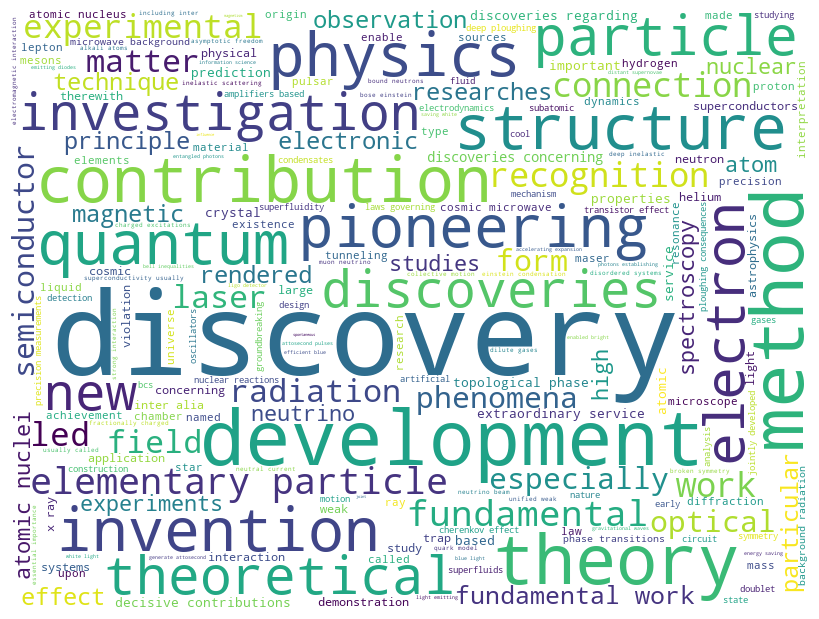

In [4]:
# generating the word cloud
wordcloud = WordCloud(width = 800, height = 600,
                      background_color = "white") \
                      .generate(words)

# making it look nice
plt.figure(figsize = (8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In the wordcloud we see various physics-related words like electron, quantum, particle, and of course "physics" itself. The most common word seems to be discovery, which is definatley not the top word for all prize categories. You wouldn't see that word in motivations for the prize in e.g. literature.

# Web Scraping

To Scrape from a website you mainly have to examine the html code to find what you want and what path to take to get there. First, since we only need to srape three pages, i'll opt to directly access these pages rather that programmatically find them. Now the next step is to find where the links to the relevant books are located. Inspecting the html, we find that the links to each book is in a `<li>` tag, contained in the `<div>` tag with class `image_container`, and the `<h3>` tag's text. I'll opt for accessing the `<image_container>` tag.

In [5]:
# pages to scrape from
pages = ["https://books.toscrape.com/catalogue/page-1.html",
        "https://books.toscrape.com/catalogue/page-2.html",
        "https://books.toscrape.com/catalogue/page-3.html"]

# finding links to all book pages
booklinks = []

for page in pages:
    
    r = requests.get(page)
    html = bs(r.content)
    # this gives us a list of beutifulsoup tags 
    books = html.find_all(class_ = "image_container")
    
    for tag in books:
        # the attribute of the tag <a> is the link we want
        booklinks.append("https://books.toscrape.com/catalogue/" + tag.find("a").attrs["href"])
        
booklinks[:5]

['https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html',
 'https://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html',
 'https://books.toscrape.com/catalogue/soumission_998/index.html',
 'https://books.toscrape.com/catalogue/sharp-objects_997/index.html',
 'https://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html']

Now that we have links to each book, we want to examine the html of the book pages. The upc is only located in the table lower down, contained in a `<td>` tag next to a `<th>` tag. This `<th>` has the text "UPC" in it, which can act as a unique identifier in the html for where the upc is located. So if we find that and look for its sibling we have our upc. Finding the title, prize, and rating is much easier, since they are all next to eachother within the `<div> class="col-sm-6 product_main"</div>` tag.

In [6]:
# initializing a dataframe to store our info
book_df = pd.DataFrame(columns = ["upc","title","price","rating"])

for link in booklinks:
    r = requests.get(link)
    book_html = bs(r.content)
    
    # find where the upc is, the sibling contains it
    upc = book_html.find_all(name = "th", string = "UPC")[0]\
            .find_next_sibling().string
    
    # zooming in on the location of the other three values
    temp = book_html.find(name = "div", class_="col-sm-6 product_main")
    
    title = temp.find(name = "h1").string
    price = temp.find(name = "p", class_ = "price_color").string
    # when finding the star rating, the "class" attribute has two values, first is star-rating, and the other is the value
    rating = temp.find(class_ = r"star-rating").attrs["class"][1]

    
    # adding our data as a row in the dataframe
    book_df.loc[len(book_df)] = [upc, title, price, rating]
    
    

In [7]:
book_df.head()

,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
